In [117]:
import numpy as np
import pandas as pd
import xarray as xr
from scipy.stats import linregress
import matplotlib.pyplot as plt

# Estimated immunity vs. cumulative cases

In [143]:
# settings
strain = 'B'
n_strains = 3
model_name = f'SIR-{n_strains}S'
immunity_linking = False
seasons = ['2023-2024', '2019-2020', '2018-2019', '2017-2018', '2016-2017', '2015-2016', '2014-2015']
samples_training = 'exclude_2024-2025_SAMPLES_2025-04-25.nc'

# get parameter values after hierarchical training
samples = xr.open_dataset(samples_training)
f_R = []
for season in seasons:
    f_R.append(samples['f_R'].sel(season=season).median(dim=['iteration', 'chain']).values)
f_R = np.array(f_R)
f_R = pd.DataFrame(data=f_R, index=seasons,columns=['AH1', 'AH3', 'B'])

# get historical cumulative totals
from hierarchSIR.utils import get_cumulatives_per_season
if n_strains == 2:
    historic_cumulative_incidence = get_cumulatives_per_season()[['H_inc_A', 'H_inc_B']]
elif n_strains == 3:
    historic_cumulative_incidence = get_cumulatives_per_season()[['H_inc_AH1', 'H_inc_AH3', 'H_inc_B']]

In [144]:
historic_cumulative_incidence

H_inc_AH1    H_inc_AH3      H_inc_B
season    horizon                                       
2014-2015  0         15.541056  3050.154711   450.304233
          -1       1553.522338   110.798417   117.679245
          -2        181.695762  1916.562611   575.741627
          -3         39.357529    77.622734    88.118421
2015-2016  0       1599.940350   307.628697   660.430953
          -1         15.541056  3050.154711   450.304233
          -2       1553.522338   110.798417   117.679245
          -3        181.695762  1916.562611   575.741627
2016-2017  0        197.279751  4197.781723  1916.938526
          -1       1599.940350   307.628697   660.430953
          -2         15.541056  3050.154711   450.304233
          -3       1553.522338   110.798417   117.679245
2017-2018  0       1722.718098  5122.754686  2520.527216
          -1        197.279751  4197.781723  1916.938526
          -2       1599.940350   307.628697   660.430953
          -3         15.541056  3050.154711   450.304233
2018-2019  0       2329.401749  4721.070152   326.528100
          -1       1722.718098  5122.754686  2520.527216
          -2        197.279751  4197.781723  1916.938526
          -3       1599.940350   307.628697   660.430953
2019-2020  0       4106.841396   140.497630  2512.660975
          -1       2329.401749  4721.070152   326.528100
          -2       1722.718098  5122.754686  2520.527216
          -3        197.279751  4197.781723  1916.938526
2022-2023  0       2627.016705  5031.831471     1.151824
          -1          7.000000  1279.718251    11.281749
          -2        235.500000    31.000000   266.500000
          -3       4106.841396   140.497630  2512.660975
2023-2024  0       4769.264416  1826.037937  4050.697647
          -1       2627.016705  5031.831471     1.151824
          -2          7.000000  1279.718251    11.281749
          -3        235.500000    31.000000   266.500000
2024-2025  0       7024.578305  6908.591986   514.826612
          -1       4769.264416  1826.037937  4050.697647
          -2       2627.016705  5031.831471     1.151824
          -3          7.000000  1279.718251    11.281749

In [145]:
# rename dataframe
df_raw = historic_cumulative_incidence

# Step 1: Restructure to one row per season
df_model = df_raw.unstack(level='horizon')
df_model.columns = [f"{col}_lag{-lag}" for col, lag in df_model.columns]

# Step 2: Compute correlation matrix of lagged features with current season (lag0)
lag0_cols = [col for col in df_model.columns if "_lag0" in col]
correlations = {}

for col in df_model.columns:
    if "_lag0" not in col:
        for lag0_col in lag0_cols:
            correlations[(col, lag0_col)] = df_model[col].corr(df_model[lag0_col])

# Convert to DataFrame
cor_df = pd.DataFrame.from_dict(correlations, orient="index", columns=["correlation"])
cor_df.index = pd.MultiIndex.from_tuples(cor_df.index, names=["lagged_feature", "target_feature"])
cor_df = cor_df.sort_values(by="correlation", ascending=False)



<>:36: SyntaxWarning: invalid escape sequence '\h'
<>:36: SyntaxWarning: invalid escape sequence '\h'
/var/folders/61/1ybw0dkj0n3b7ds4ly3_wzcm0000gn/T/ipykernel_62976/526502677.py:36: SyntaxWarning: invalid escape sequence '\h'
  ax[0].set_ylabel('$\hat{f}_{R,i}$')


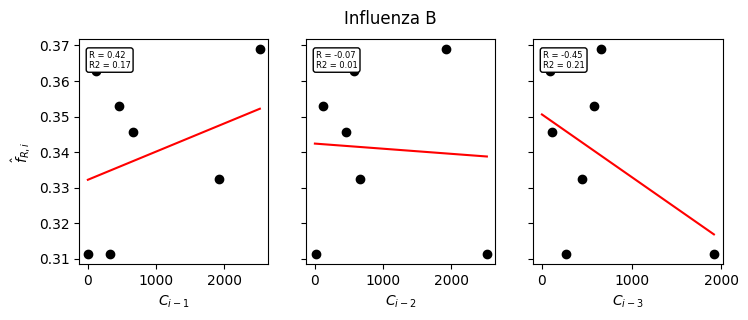

In [146]:
modeled_immunity = True
fig,ax=plt.subplots(ncols=3, sharey=True, figsize=(8.3,11.7/4))
x_1=[]
x_2=[]
x_3=[]
y=[]
for season in seasons:
    # look up strain
    x_1.append(historic_cumulative_incidence.loc[season][f'H_inc_{strain}'].values[1])
    x_2.append(historic_cumulative_incidence.loc[season][f'H_inc_{strain}'].values[2])
    x_3.append(historic_cumulative_incidence.loc[season][f'H_inc_{strain}'].values[3])
    if modeled_immunity:
        y.append(f_R.loc[season][strain])
    else:
        y.append(historic_cumulative_incidence.loc[season][f'H_inc_{strain}'].values[0])

# linear regressions
slope_1, intercept_1, r_value_1, _, _ = linregress(x_1, y)
slope_2, intercept_2, r_value_2, _, _ = linregress(x_2, y)
slope_3, intercept_3, r_value_3, _, _ = linregress(x_3, y)

# add linear regressions to figure
ax[0].plot(np.linspace(0,max(x_1)), np.linspace(0,2000)*slope_1 + intercept_1, color='red')
ax[0].text(0.05, 0.95, f"R = {r_value_1:.2f}\nR2 = {r_value_1**2:.2f}", transform=ax[0].transAxes,fontsize=6, verticalalignment='top',bbox=dict(boxstyle="round", facecolor='white', edgecolor='black'))
ax[1].plot(np.linspace(0,max(x_2)), np.linspace(0,2000)*slope_2 + intercept_2, color='red')
ax[1].text(0.05, 0.95, f"R = {r_value_2:.2f}\nR2 = {r_value_2**2:.2f}", transform=ax[1].transAxes,fontsize=6, verticalalignment='top',bbox=dict(boxstyle="round", facecolor='white', edgecolor='black'))
ax[2].plot(np.linspace(0,max(x_3)), np.linspace(0,2000)*slope_3 + intercept_3, color='red')
ax[2].text(0.05, 0.95, f"R = {r_value_3:.2f}\nR2 = {r_value_3**2:.2f}", transform=ax[2].transAxes,fontsize=6, verticalalignment='top',bbox=dict(boxstyle="round", facecolor='white', edgecolor='black'))

# add data to visualisation
ax[0].scatter(x_1, y, color='black', marker='o')
ax[1].scatter(x_2, y, color='black', marker='o')
ax[2].scatter(x_3, y, color='black', marker='o')

if modeled_immunity:
    ax[0].set_ylabel('$\hat{f}_{R,i}$')
else:
    ax[0].set_ylabel('$C_{i}$')
ax[0].set_xlabel('$C_{i-1}$')
ax[1].set_xlabel('$C_{i-2}$')
ax[2].set_xlabel('$C_{i-3}$')
plt.suptitle(f'Influenza {strain}')
plt.show()
plt.close()

In [147]:
def immunity_model(iota_min1, iota_min2, iota_min3, C_min1, C_min2, C_min3):
    X = iota_min1 * C_min1 + iota_min2 * C_min2 + iota_min3 * C_min3
    return X/(1+X)


def SSE(theta):

    iota_min1, iota_min2, iota_min3 = theta

    SSE = []
    for season in seasons:
        # get cumulative totals (x)
        C_min1 = historic_cumulative_incidence.loc[season][f'H_inc_{strain}'].values[1]
        C_min2 = historic_cumulative_incidence.loc[season][f'H_inc_{strain}'].values[2]
        C_min3 = historic_cumulative_incidence.loc[season][f'H_inc_{strain}'].values[3]

        # get data (y)
        y = f_R.loc[season][strain]

        # forecast data (y_hat)
        y_hat = immunity_model(iota_min1, iota_min2, iota_min3, C_min1, C_min2, C_min3)

        SSE.append((y-y_hat)**2)

    return sum(SSE)

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.21025970486382967
        x: [ 2.131e-04  7.553e-05  3.711e-04]
      nit: 9
      jac: [ 1.497e-03  1.333e-03  9.197e-04]
     nfev: 68
     njev: 17
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


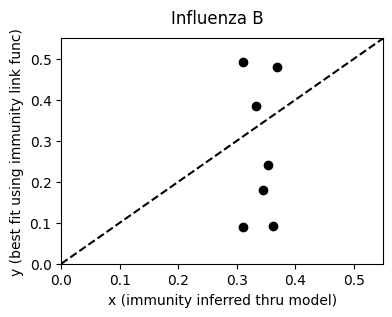

In [148]:
# optimize model
from scipy.optimize import minimize
initial_guess = [1E-4, 1E-4, 1E-4]                   
bounds = [(None, None), (None, None), (None, None)]     
result = minimize(SSE, initial_guess, bounds=bounds, method='L-BFGS-B')
iota_min1, iota_min2, iota_min3 = result.x
print(result)

# visualise
y=[]
y_hat=[]
for season in seasons:
    # get cumulative totals (x)
    C_min1 = historic_cumulative_incidence.loc[season][f'H_inc_{strain}'].values[1]
    C_min2 = historic_cumulative_incidence.loc[season][f'H_inc_{strain}'].values[2]
    C_min3 = historic_cumulative_incidence.loc[season][f'H_inc_{strain}'].values[3]

    # get data (y)
    y.append(f_R.loc[season][strain])

    # forecast data (y_hat)
    y_hat.append(immunity_model(iota_min1, iota_min2, iota_min3, C_min1, C_min2, C_min3))

fig,ax=plt.subplots(figsize=(8.3/2, 11.7/4))
ax.scatter(y, y_hat, color='black', marker='o')
ax.plot(np.linspace(0,1), np.linspace(0,1), color='black', linestyle='--')
ax.set_xlim([0,0.55])
ax.set_ylim([0,0.55])
ax.set_xlabel('x (immunity inferred thru model)')
ax.set_ylabel('y (best fit using immunity link func)')
plt.suptitle(f'Influenza {strain}')
plt.show()
plt.close()